The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Average Feature Importance Across Patients (Horizon: 30 min):
------------------------------------------
glucose             :  18.46% ±  3.30%
glucose_change      :  15.84% ±  3.92%
time                :  15.21% ±  4.15%
glucose_projected   :  12.16% ±  2.47%
glucose_change_projected:  10.14% ±  3.34%
dietary_fibers      :   7.74% ±  2.95%
proteins            :   5.97% ±  4.52%
complex_sugars      :   5.59% ±  3.47%
fats                :   4.95% ±  3.03%
simple_sugars       :   3.60% ±  4.33%
insulin             :   0.35% ±  0.57%

Average Feature Importance Across Patients (Horizon: 60 min):
------------------------------------------
time                :  18.49% ±  4.45%
glucose             :  16.67% ±  2.40%
glucose_change      :  10.68% ±  1.61%
glucose_change_projected:  10.05% ±  2.06%
glucose_projected   :   9.76% ±  1.62%
dietary_fibers      :   9.73% ±  2.99%
proteins            :   8.30% ±  4.50%
fats                :   6.86% ±  4.56%
complex_sugars      :   5.62% ±  3.04%


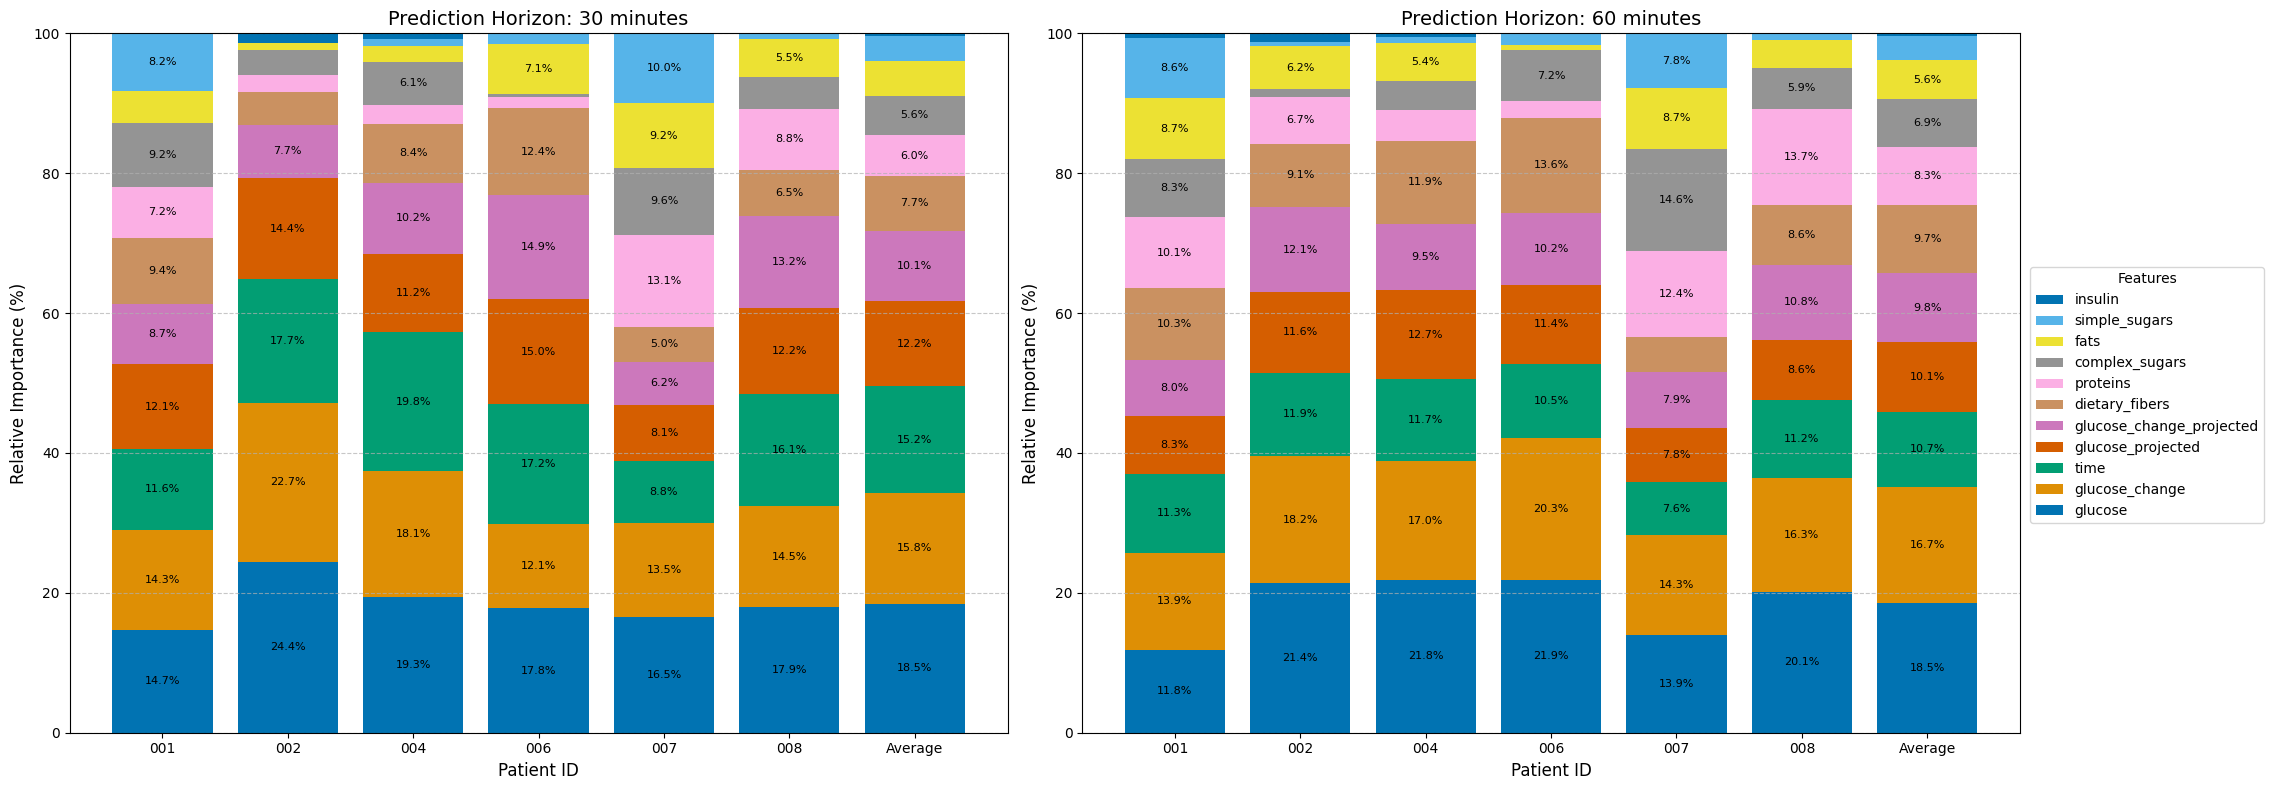

In [19]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Constants
patients = ['001', '002', '004', '006', '007', '008']
prediction_horizons = [6, 12]  # 6 = 30 minutes, 12 = 60 minutes

def load_and_process_importances(horizon):
    # Load models and extract importances
    feature_importances = {}
    model_path = f'models/pixtral-large-latest/{horizon}'
    
    for patient in patients:
        model_file = Path(model_path) / f'patient_{patient}_model.pkl'
        with open(model_file, 'rb') as f:
            model = pickle.load(f)
            # Convert to relative importance (sums to 100%)
            importances = model.feature_importances_
            relative_importances = (importances / importances.sum()) * 100
            feature_importances[patient] = dict(zip(model.feature_name_, relative_importances))
    
    return pd.DataFrame(feature_importances)

def plot_relative_importances(df, ax, title):
    # Add average column to the dataframe
    df_with_avg = df.copy()
    df_with_avg['Average'] = df.mean(axis=1)
    
    # Use a more color-blind friendly palette
    n_features = len(df_with_avg.index)
    colors = sns.color_palette("colorblind", n_features)
    
    # Create stacked bar plot
    bottom = np.zeros(len(df_with_avg.columns))
    
    for idx, feature in enumerate(df_with_avg.index):
        values = df_with_avg.loc[feature]
        ax.bar(df_with_avg.columns, values, bottom=bottom, label=feature, color=colors[idx])
        bottom += values
    
    # Customize plot
    ax.set_xlabel('Patient ID', fontsize=12)
    ax.set_ylabel('Relative Importance (%)', fontsize=12)
    ax.set_title(title, fontsize=14)
    
    # Add percentage labels inside bars
    for i in range(len(df_with_avg.columns)):
        bottom = 0
        for j in range(len(df_with_avg.index)):
            value = df_with_avg.iloc[j, i]
            if value >= 5:  # Only show labels for features with >5% importance
                ax.text(i, bottom + value/2, f'{value:.1f}%', 
                        ha='center', va='center', fontsize=8)
            bottom += value
    
    # Add gridlines
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Set y-axis to show percentages
    ax.set_ylim(0, 100)

def plot_average_importances(df, ax, title):
    # Calculate average importance across patients
    avg_importance = df.mean(axis=1)
    
    # Sort by importance
    avg_importance = avg_importance.sort_values(ascending=False)
    
    # Use a color-blind friendly palette
    colors = sns.color_palette("colorblind", len(avg_importance))
    
    # Create horizontal bar plot
    bars = ax.barh(avg_importance.index, avg_importance, color=colors)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 1, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}%', va='center')
    
    # Customize plot
    ax.set_xlabel('Average Relative Importance (%)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    ax.set_xlim(0, max(avg_importance) * 1.1)  # Add some space for labels

# Create figure with three subplots
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

# Process and plot for each prediction horizon
for i, horizon in enumerate(prediction_horizons):
    # Get feature importances
    importances_df = load_and_process_importances(horizon)
    
    # Sort features by average importance
    avg_importance = importances_df.mean(axis=1)
    importances_df = importances_df.reindex(avg_importance.sort_values(ascending=False).index)
    
    # Create stacked bar plot
    title = f'Prediction Horizon: {horizon*5} minutes'
    plot_relative_importances(importances_df, axes[i], title)
    
    # Print summary statistics
    print(f"\nAverage Feature Importance Across Patients (Horizon: {horizon*5} min):")
    print("------------------------------------------")
    mean_importance = importances_df.mean(axis=1)
    std_importance = importances_df.std(axis=1)
    for feature in mean_importance.index:
        print(f"{feature:20s}: {mean_importance[feature]:6.2f}% ± {std_importance[feature]:5.2f}%")

# Add a single legend for the stacked bar plots
handles, labels = axes[0].get_legend_handles_labels()
# Reverse the order of handles and labels
handles = handles[::-1]
labels = labels[::-1]
fig.legend(handles, labels, bbox_to_anchor=(0.845, 0.5), loc='center left', 
          fontsize=10, title='Features')

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Make room for the legend

plt.savefig('images/results/feature_importances.eps', dpi=300)
plt.show()